In [1]:
from spineq.optimise import get_optimisation_inputs
from spineq.utils import coverage_matrix
from spineq.plotting import plot_optimisation_result
from spineq.data_fetcher import get_oa_shapes, get_oa_centroids

import pygmo as pg

import numpy as np
import pandas as pd

from time import time

In [2]:
n_sensors = 20
theta = 500

population_weight = 1
workplace_weight = 0
pop_age_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 1},
    "pop_children": {"min": 0, "max": 16, "weight": 0},
    "pop_elderly": {"min": 70, "max": 90, "weight": 0},
}

## Get Input Data

In [3]:
data = get_optimisation_inputs(
    population_weight=population_weight,
    workplace_weight=workplace_weight,
    pop_age_groups=pop_age_groups,
    combine=True,
)

data.keys()

dict_keys(['oa11cd', 'oa_x', 'oa_y', 'oa_weight'])

## PyGMO: vector of 0/1s for sensor at location or not

Fails to even meet constraints. But assume it has to "learn" how to make the vector sum up to n_sensors, which seems difficult.

In [4]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, oa_x, oa_y, oa_weight,
                 n_sensors, theta):
        
        self.n_sensors = n_sensors
        self.oa_weight = oa_weight
        self.coverage = coverage_matrix(oa_x, oa_y, theta=theta)
        
        # dimension of problem = number of candidate sensor locations
        self.dim = len(oa_x)
          
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # only keep coverages due to output areas where a sensor is present
        mask_cov = np.multiply(self.coverage, sensors[np.newaxis, :])

        # coverage at each output area = coverage due to nearest sensor
        max_mask_cov = np.max(mask_cov, axis=1)
        
        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.oa_weight * max_mask_cov).sum() / self.oa_weight.sum()

        # constraint: have n_sensors sensors
        # equality constraints: must equal zero
        constraint_n_sensors = sensors.sum() - self.n_sensors
        
        return [fitness_sensors, constraint_n_sensors]
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.dim, [1]*self.dim)
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 1
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.dim
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    


In [5]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)

print(prob)

Problem name: <class '__main__.population_optimisation'>
	C++ class name: pybind11::object

	Global dimension:			952
	Integer dimension:			952
	Fitness dimension:			2
	Number of objectives:			1
	Equality constraints dimension:		1
	Inequality constraints dimension:	0
	Tolerances on constraints: [0]
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 1904
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [6]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco(gen=100))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: GACO: Ant Colony Optimization [stochastic]
	C++ class name: pagmo::gaco

	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 3703322221 3026474855 3726542811 3483775035 3454467612 3774470464 2896990837 2948102138 4089646304 2886635672 2572646092 1975000401 2256756892 2900077667 1687284563 3418274153 1029628130 2062920507 572823540 627935063 3372545127 3564760969 3658636168 17334510 3822861310 568922090 1105035628 211969308 2012340264 813850954 3397844048 244250590 2954860726 2182845221 2427579781 3238065510 4202094077 2812576603 1369535299 2586757937 4053366343 1571949821 3944086422 1080164084 751678421 2302144566 2483656882 4149177759 3812801212 243065996 3714652014 939168564 621733816 2397758413 2772346849 348501958 2412017494 2410350685 2223908021 246175

In [7]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 10100
g evals 0
champion f [ -0.79563516 384.        ]
n_sensors 404.0
min sensors at location 0.0
max sensors at location 1.0


In [8]:
def pygmo_result_dict(pop, data, theta):
    """Convert PyGMO optimised population into result dict
    with format needed for plot_optimisation_result.
    pop: evolved population
    data: input optimisation data from get_optimisation_inputs
    theta: coverage decay rate parameter
    """
    sensors = pop.champion_x

    coverage = coverage_matrix(data["oa_x"], data["oa_y"], theta=theta)
    mask_cov = np.multiply(coverage, sensors[np.newaxis, :])
    oa_coverage = np.max(mask_cov, axis=1)

    n_poi = len(data["oa_x"])

    sensors = [
        {"x": data["oa_x"][i], "y": data["oa_y"][i], "oa11cd": data["oa11cd"][i]}
        for i in range(n_poi)
        if sensors[i] == 1
    ]

    oa_coverage = [
        {"oa11cd": data["oa11cd"][i], "coverage": oa_coverage[i]} for i in range(n_poi)
    ]

    total_coverage = - pop.champion_f[0]

    result = {"sensors": sensors, "oa_coverage": oa_coverage, "total_coverage": total_coverage}
    
    return result

/Users/jroberts/GitHub/spatial-inequality/spineq/plotting.py:90: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ax, url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png", crs=oa_shapes.crs.to_epsg()


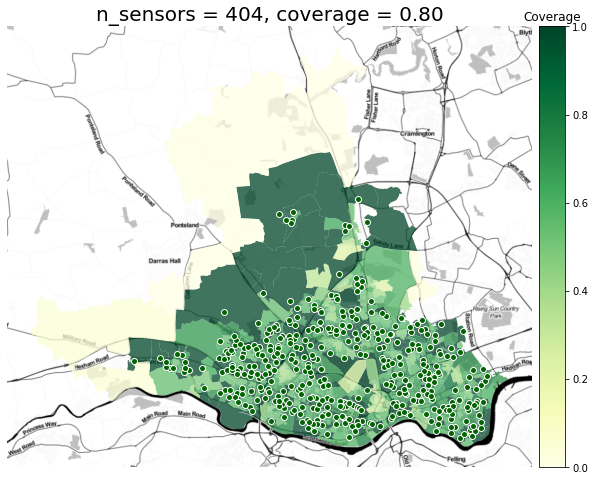

In [9]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)

## PyGMO: Sensors at any arbitrary position (not only output area centroids)

In [10]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, oa_x, oa_y, oa_weight,
                 n_sensors, theta):
        
        self.n_sensors = n_sensors
        self.oa_weight = oa_weight
        self.oa_x = oa_x
        self.oa_y = oa_y
        self.theta = theta
        
        self.min_x = oa_x.min()
        self.min_y = oa_y.min()
        self.max_x = oa_x.max()
        self.max_y = oa_y.max()
          
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # extract sensor x and y positions
        sensors_x = sensors[0::2]
        sensors_y = sensors[1::2]

        # coverage at each output area due to each sensor
        coverage = coverage_matrix(sensors_x, sensors_y,
                                   self.oa_x, self.oa_y, theta=self.theta)
        
        # coverage at each output area = coverage due to nearest sensor
        max_cov = np.max(coverage, axis=0)
        
        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.oa_weight * max_cov).sum() / self.oa_weight.sum()
        
        return [fitness_sensors]
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([self.min_x, self.min_y]*self.n_sensors,
                [self.max_x, self.max_y]*self.n_sensors)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

In [11]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)

print(prob)

Problem name: <class '__main__.population_optimisation'>
	C++ class name: pybind11::object

	Global dimension:			40
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [413067, 563224, 413067, 563224, 413067, ... ]
	Upper bounds: [429850, 577386, 429850, 577386, 429850, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 40
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [12]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco(gen=100))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)

Algorithm name: GACO: Ant Colony Optimization [stochastic]
	C++ class name: pagmo::gaco

	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 2761264881 1697018080 2092560839 3693697313 3304152174 1621806086 314785225 1603727700 4077302673 4173068963 363430186 2183491485 2195333319 1559976646 2721075089 145362958 3323057046 1414936282 1297864569 802372203 2777042763 627726562 1924399936 428478908 3273300804 1770603036 575904395 645749746 3779578006 2747064294 4237383954 158940372 3090052036 951231295 42999549 3093077748 1851153714 3495432260 3110431529 2106215198 2879142499 3565678958 802198827 3041647906 2888064460 3643687027 1925930078 3108194474 4127560312 4042497464 2745388537 4194703162 2506336945 1972446164 3846381631 2438976483 1515782397 2642952101 1113750557 436859

In [13]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("sensors", pop.champion_x)

f evals 10100
g evals 0
champion f [-0.24207756]
sensors [427007.25922492 568013.79813251 424938.31240902 567816.77642951
 427041.93537103 564940.48199371 423289.43311738 564730.00533622
 425144.62036723 575269.83188435 422726.06442313 567748.27626145
 428363.29002081 573267.04748976 425414.90931865 567160.91387726
 423285.16425378 570018.12335749 426284.0667736  565815.27381331
 413081.54819137 564944.26663341 425607.85525574 565014.32959549
 420352.76962556 566235.70619446 424617.168155   564965.43949772
 425959.16373944 564137.07168339 419245.08492814 566072.77652801
 420773.49412112 564311.04334012 423860.39579646 564219.31772902
 423517.7676812  568430.29784187 421450.9979502  564697.3884159 ]


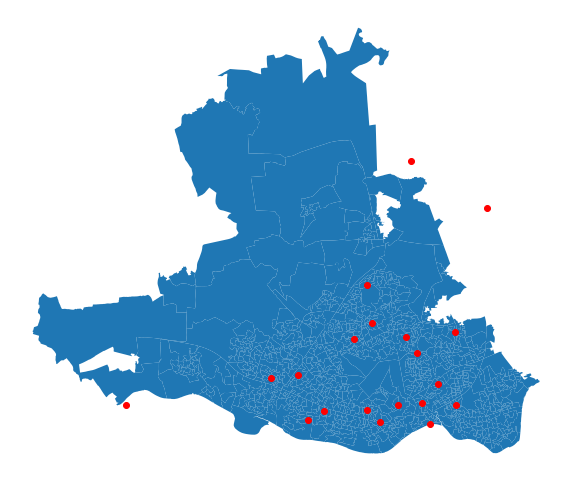

In [14]:
oa_shapes = get_oa_shapes()

ax = oa_shapes.plot(figsize=(10,10))
ax.set_axis_off()

sensors = pop.champion_x
sensors_x = sensors[0::2]
sensors_y = sensors[1::2]
ax.scatter(sensors_x,sensors_y, color='r')

## PyGMO Sensors by Index

One decision variable for each sensor to be placed, variable value is index of location.

In [15]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, oa_x, oa_y, oa_weight,
                 n_sensors, theta):
        
        self.n_sensors = n_sensors
        self.n_locations = len(oa_x)
        self.oa_weight = oa_weight
        self.coverage = coverage_matrix(oa_x, oa_y, theta=theta)
          
    def fitness(self, sensors_idx):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # Construct sensors vector from indices
        sensors = np.zeros(self.n_locations)
        sensors[sensors_idx.astype(int)] = 1
        
        # only keep coverages due to output areas where a sensor is present
        mask_cov = np.multiply(self.coverage, sensors[np.newaxis, :])

        # coverage at each output area = coverage due to nearest sensor
        max_mask_cov = np.max(mask_cov, axis=1)
        
        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.oa_weight * max_mask_cov).sum() / self.oa_weight.sum()

        # constraint: all sensors at different locations
        # equality constraints: must equal zero
        #constraint_sensors = self.n_sensors - len(set(sensors_idx))
        
        return [fitness_sensors]#, constraint_sensors]
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.n_sensors, [self.n_locations-1]*self.n_sensors)
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 0 #1
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.n_sensors
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    


In [16]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)

print(prob)

Problem name: <class '__main__.population_optimisation'>
	C++ class name: pybind11::object

	Global dimension:			20
	Integer dimension:			20
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [951, 951, 951, 951, 951, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 20
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [17]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco(gen=100))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: GACO: Ant Colony Optimization [stochastic]
	C++ class name: pagmo::gaco

	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 3051815896 2016030467 484089292 3242618239 1069846000 2047963061 2073323018 2591368542 1991899476 186702738 2457191076 673882505 3758296089 1331933263 1708149972 2585742616 2723304786 793999521 2414067863 3338516444 1687740943 2544676251 2335596147 1175763884 3696795737 3074256283 3054640759 3097862468 1838225082 1652886244 4187281783 38067939 2628283055 3594759010 1527809639 2050727009 3872657924 25287656 4198689454 4072156008 2782028895 4265762266 4049020871 2718340223 1031436925 3796514942 1190014591 3763062245 2081892846 1411215996 3477999747 69272243 3797736403 3270838597 3582795476 1376729610 3227437455 840265845 2866215779 1056

In [18]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 10100
g evals 0
champion f [-0.29050725]
n_sensors 9603.0
min sensors at location 62.0
max sensors at location 894.0


In [19]:
def pygmo_result_dict(pop, data, theta):
    """Convert PyGMO optimised population into result dict
    with format needed for plot_optimisation_result.
    pop: evolved population
    data: input optimisation data from get_optimisation_inputs
    theta: coverage decay rate parameter
    """
    
    n_poi = len(data["oa_x"])

    sensors_idx = pop.champion_x
    
    # Construct sensors vector from indices
    sensors = np.zeros(n_poi)
    sensors[sensors_idx.astype(int)] = 1
    
    coverage = coverage_matrix(data["oa_x"], data["oa_y"], theta=theta)
    mask_cov = np.multiply(coverage, sensors[np.newaxis, :])
    oa_coverage = np.max(mask_cov, axis=1)

    sensors = [
        {"x": data["oa_x"][i], "y": data["oa_y"][i], "oa11cd": data["oa11cd"][i]}
        for i in range(n_poi)
        if sensors[i] == 1
    ]

    oa_coverage = [
        {"oa11cd": data["oa11cd"][i], "coverage": oa_coverage[i]} for i in range(n_poi)
    ]

    total_coverage = - pop.champion_f[0]

    result = {"sensors": sensors, "oa_coverage": oa_coverage, "total_coverage": total_coverage}
    
    return result

/Users/jroberts/GitHub/spatial-inequality/spineq/plotting.py:90: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ax, url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png", crs=oa_shapes.crs.to_epsg()


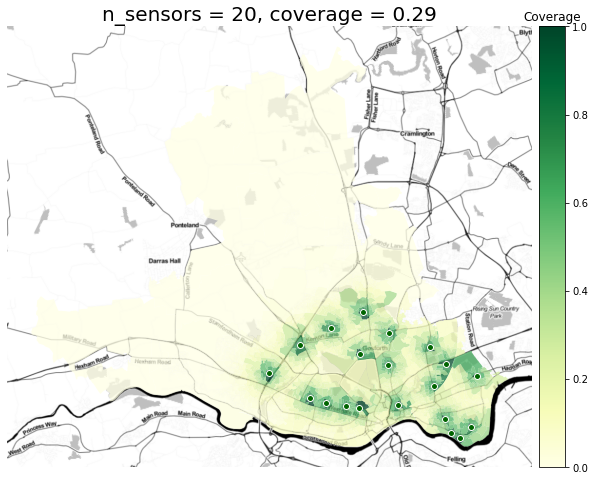

In [20]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)

## Compare Algorithms

In [21]:
algorithms = [
    {"name": "Extended Ant Colony Optimization (GACO)", "fn": pg.gaco},
    {"name": "Differential Evolution (DE)", "fn":  pg.de},
    {"name": "Self-adaptive DE (jDE and iDE)", "fn":  pg.sade},
    {"name": "Self-adaptive DE (de_1220 aka pDE)", "fn":  pg.de1220},
    {"name": "Grey wolf optimizer (GWO)", "fn":  pg.gwo},
    {"name": "Improved Harmony Search", "fn":  pg.ihs},
    {"name": "Particle Swarm Optimization (PSO)", "fn":  pg.pso},
    {"name": "Particle Swarm Optimization Generational (GPSO)", "fn":  pg.pso_gen},
    {"name": "(N+1)-ES Simple Evolutionary Algorithm", "fn":  pg.sea},
    {"name": "Simple Genetic Algorithm", "fn":  pg.sga},
    {"name": "Corana’s Simulated Annealing (SA)", "fn":  pg.simulated_annealing},
    {"name": "Artificial Bee Colony (ABC)", "fn":  pg.bee_colony},
    {"name": "Covariance Matrix Adaptation Evo. Strategy (CMA-ES)", "fn":  pg.cmaes},
    {"name": "Exponential Evolution Strategies (xNES)", "fn":  pg.xnes},
]

In [22]:
def run_opt(prob, uda, gen=100, size=100):
    start_time = time()
    
    # Create algorithm to solve problem with
    algo = pg.algorithm(uda = uda(gen=gen))
    algo.set_verbosity(1)

    # population of problems
    pop = pg.population(prob=prob, size=size)

    # solve problem
    pop = algo.evolve(pop)

    elapsed = time() - start_time
    score = -pop.champion_f[0]
    
    return score, elapsed

In [23]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)
print(prob)
print("-"*30)

for i, alg in enumerate(algorithms):
    print("Doing",alg["name"])
    try:
        score, elapsed = run_opt(prob, alg["fn"])
        algorithms[i]["score"] = score
        algorithms[i]["time"] = elapsed
        print("Score:", score)
        print("Time:", elapsed)
    except Exception as e:
        print(f"Error {e}")
    
    print("-"*30)

Problem name: <class '__main__.population_optimisation'>
	C++ class name: pybind11::object

	Global dimension:			20
	Integer dimension:			20
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [951, 951, 951, 951, 951, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 20
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none

------------------------------
Doing Extended Ant Colony Optimization (GACO)
Score: 0.29025600314503064
Time: 53.55477285385132
------------------------------
Doing Differential Evolution (DE)
Score: 0.30003034309011695
Time: 49.14114689826965
------------------------------
Doing Self-adaptive DE (jDE and iDE)
Score: 0.31542084751876953
Time: 48.34176683425903
--------------------------

In [24]:
df = pd.DataFrame(algorithms)

print("BEST SCORE:")
display(df.sort_values(by="score", ascending=False).head())

print("FASTEST:")
display(df.sort_values(by="time", ascending=True).head())

BEST SCORE:


,name,fn,score,time
9,Simple Genetic Algorithm,<class 'pygmo.core.sga'>,0.324175,37.758503
2,Self-adaptive DE (jDE and iDE),<class 'pygmo.core.sade'>,0.315421,48.341767
11,Artificial Bee Colony (ABC),<class 'pygmo.core.bee_colony'>,0.313144,61.691354
3,Self-adaptive DE (de_1220 aka pDE),<class 'pygmo.core.de1220'>,0.309115,49.949746
1,Differential Evolution (DE),<class 'pygmo.core.de'>,0.300030,49.141147


FASTEST:


,name,fn,score,time
8,(N+1)-ES Simple Evolutionary Algorithm,<class 'pygmo.core.sea'>,0.291522,0.695287
5,Improved Harmony Search,<class 'pygmo.core.ihs'>,0.275598,0.944334
7,Particle Swarm Optimization Generational (GPSO),<class 'pygmo.core.pso_gen'>,0.293124,35.246594
9,Simple Genetic Algorithm,<class 'pygmo.core.sga'>,0.324175,37.758503
2,Self-adaptive DE (jDE and iDE),<class 'pygmo.core.sade'>,0.315421,48.341767


## Results
- Simple genetic algorithm (pg.sga) - generally best score 
- Simple evolutionary algorithm (pg.sea) - good score and generally fastest

## Simple Genetic Algorithm

In [25]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.sga(gen=200))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=200)


Algorithm name: SGA: Genetic Algorithm [stochastic]
	C++ class name: pagmo::sga

	Thread safety: basic

Extra info:
	Number of generations: 200
	Crossover:
		Type: exponential
		Probability: 0.9
	Mutation:
		Type: polynomial
		Probability: 0.02
		Distribution index: 1
	Selection:
		Type: tournament
		Tournament size: 2
	Seed: 3335577796
	Verbosity: 1


In [26]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 40200
g evals 0
champion f [-0.33343689]
n_sensors 7174.0
min sensors at location 7.0
max sensors at location 878.0


/Users/jroberts/GitHub/spatial-inequality/spineq/plotting.py:90: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ax, url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png", crs=oa_shapes.crs.to_epsg()


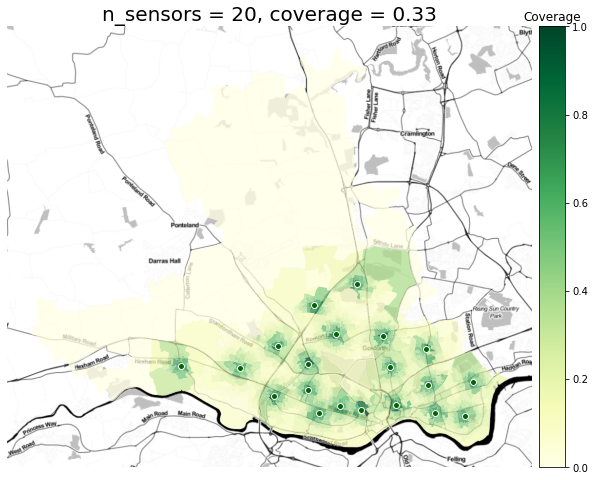

In [27]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)

## Simple Evolutionary Algorithm

In [28]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.sea(gen=20000))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=1000)


Algorithm name: SEA: (N+1)-EA Simple Evolutionary Algorithm [stochastic]
	C++ class name: pagmo::sea

	Thread safety: basic

Extra info:
	Generations: 20000
	Verbosity: 1
	Seed: 829970526


In [29]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 21000
g evals 0
champion f [-0.33403441]
n_sensors 8609.48919333662
min sensors at location 44.06663161285667
max sensors at location 842.2418121559828


/Users/jroberts/GitHub/spatial-inequality/spineq/plotting.py:90: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ax, url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png", crs=oa_shapes.crs.to_epsg()


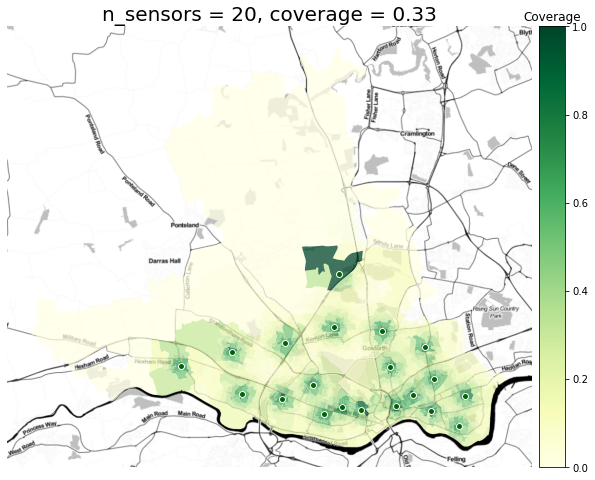

In [30]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)